## ECS763 Natural Language Processing
## Name: Michael Capaldi
## Student ID: 210641428

## Code taken from Assignment_1_CRF_tagging_in_Movie_Queries

In [1]:
import os
import sys

from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import re
import unicodedata

In [2]:
def get_raw_data_from_bio_file(fpath):
    """A simple function to read in from a one-word-per-line BIO
    (Beginning, Inside, Outside) tagged corpus, tab separated
    and each example sentence/text separated with a blank line.
    The data is already tokenized in a simple way.
    e.g.:
    
    B-Actor	steve
    I-Actor	mcqueen
    O	provided
    O	a
    B-Plot	thrilling
    I-Plot	motorcycle
    I-Plot	chase
    I-Plot	in
    I-Plot	this
    B-Opinion	greatest
    I-Opinion	of
    I-Opinion	all
    B-Plot	ww
    I-Plot	2
    I-Plot	prison
    I-Plot	escape
    I-Plot	movies
    
    returns a list of lists of tuples of (word, tag) tuples
    """
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

In [3]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    feature_list.append("WORD_" + token)
    #print(feature_list)
    return feature_list

In [4]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!

# Question 1

In [5]:
# collecting the raw training data
training_data = get_raw_data_from_bio_file("./trivia10k13train.bio.txt") 

In [6]:
# importing train_test_split in order to split the dataset
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(training_data, test_size=0.2, random_state=101)

In [7]:
# Train the CRF BIO-tag tagger

# path to the tagger- it will save/access the model from here
TAGGER_PATH = "crf_nlu.tagger"  
# initialize tagger with get_features function
# for now get_features function remains the same as the function given in the assignment notebook
ct = CRFTagger(feature_func=get_features)  
print("training tagger...")
ct.train(X_train, TAGGER_PATH)
print("done")

training tagger...
done


In [8]:
print("testing tagger...")
preds = []
y_test = []
for sent in X_test:
    # tuple unpacking for the predicted sequence tags
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    # tuple unpacking the ground truth values
    sent_true = [s[1] for s in sent]
    
    # adding each prediction and truth labels to lists declared above the for loop
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [9]:
# Output the classification report 
print(classification_report(y_test, preds))
# print out accurate macro score
print(precision_recall_fscore_support(y_test, preds, average='macro'))  

                  precision    recall  f1-score   support

         B-Actor       0.87      0.89      0.88       999
         B-Award       0.76      0.58      0.65        59
B-Character_Name       0.62      0.18      0.28       175
      B-Director       0.83      0.72      0.77       360
         B-Genre       0.85      0.75      0.79       692
       B-Opinion       0.43      0.27      0.33       159
        B-Origin       0.54      0.35      0.42       145
          B-Plot       0.51      0.48      0.49      1308
         B-Quote       0.62      0.33      0.43        24
  B-Relationship       0.75      0.46      0.57       116
    B-Soundtrack       1.00      0.10      0.18        10
          B-Year       0.95      0.98      0.97       540
         I-Actor       0.87      0.89      0.88      1235
         I-Award       0.72      0.68      0.70       122
I-Character_Name       0.59      0.22      0.32       116
      I-Director       0.82      0.72      0.77       326
         I-Ge

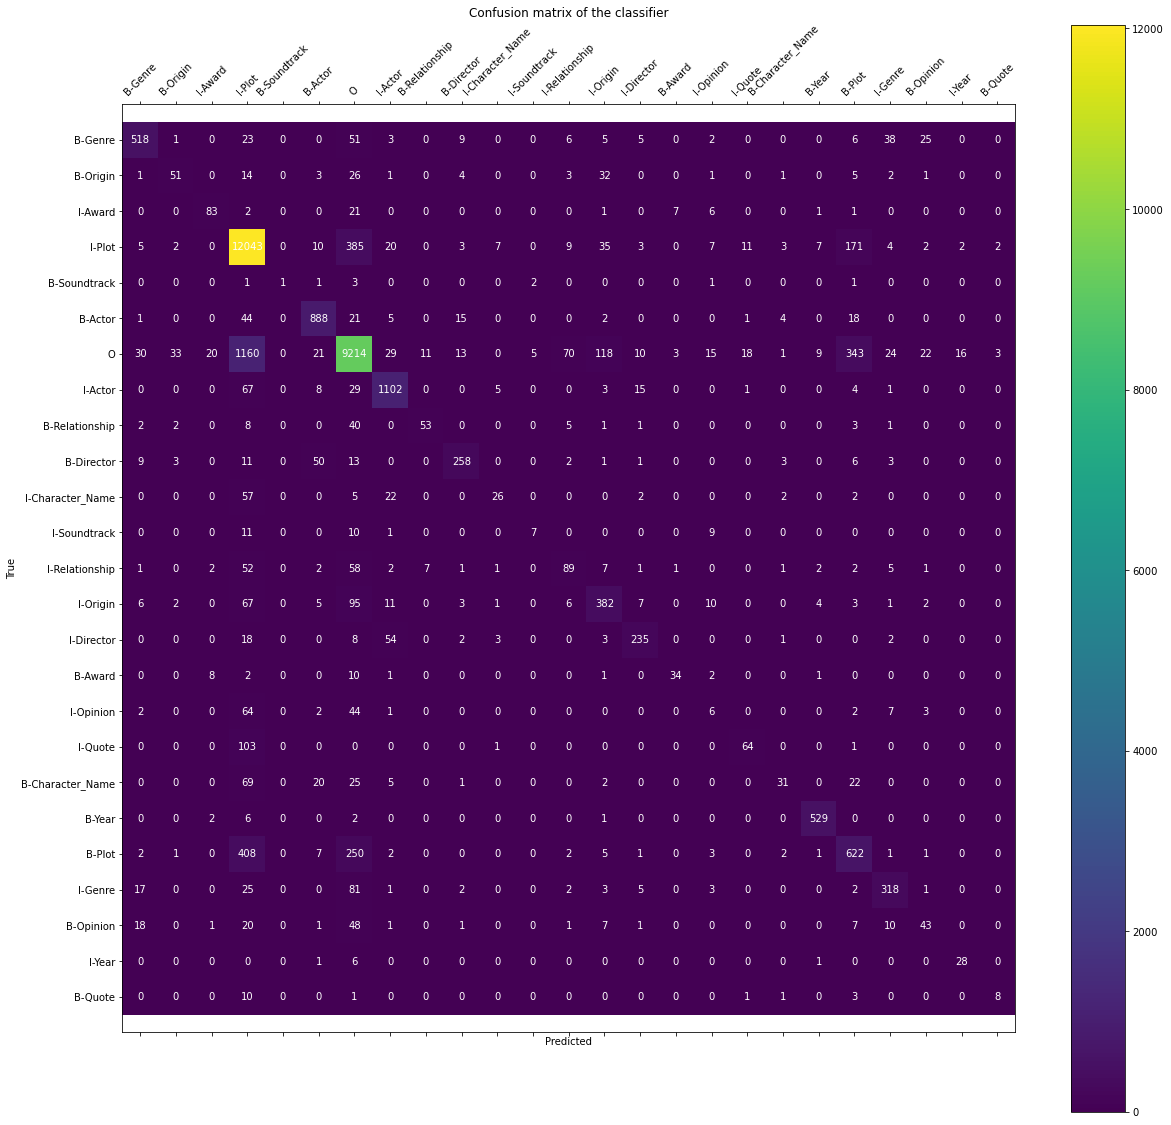

In [10]:
# using the confusion matrix heatmap function to illustrate our results
# note the horizontal values represent our false negatives (except the values on the diagonal)
# ..and the vertical values show the false positives. 
confusion_matrix_heatmap(y_test, preds)

# Question 2

In [11]:
# Utilising pandas to organise the lowest precision scores 
import pandas as pd
report_results = classification_report(y_test, preds, output_dict=True)
results = pd.DataFrame(report_results).transpose()
results = results.iloc[:-3]
results.sort_values('precision').head(5)

,precision,recall,f1-score,support
I-Opinion,0.092308,0.045802,0.061224,131.0
B-Opinion,0.425743,0.270440,0.330769,159.0
I-Relationship,0.456410,0.378723,0.413953,235.0
I-Soundtrack,0.500000,0.184211,0.269231,38.0
B-Plot,0.508170,0.475535,0.491311,1308.0


In [12]:
# will use our lowest precision scores as target values below
lowest_precision = ['I-Opinion','B-Opinion','I-Relationship','I-Soundtrack','B-Plot']

In [13]:
# setting a count to record the number of false positives for each of the lowest precision categories
count_i_op = 0
count_b_op = 0
count_i_rl = 0
count_i_sd = 0
count_b_pl = 0
preds = []
y_test = []

# using tuple unpacking like before to generate truth and predicted lists
for sent in X_test:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
    
    # for loop used to go through every prediction
    for i in range(len(sent_true)):
        # if statement narrows our search to when our predicted label is one of the target categories
        if sent_preds[i] in lowest_precision:
            # selecting only false positives when the truth is not equal to the prediction
            if sent_true[i] != sent_preds[i]:
                mistake = sent[i][0] # identifying the token incorrectly predicted
                print('SENTENCE: {0} \n, PREDICTED:    {1}, \n GROUND TRUTH: {2}, \n Incorrectly predicted word: {3} \n'.format([s[0] for s in sent], sent_preds[i], sent_true[i], mistake))
                # prints the sentence, the ground truth and predicted label plus the word itself.
                # using if/elif statements to add to their respective counts
                if sent_preds[i] == 'I-Opinion':
                    count_i_op += 1
                elif sent_preds[i] == 'B-Opinion':
                    count_b_op += 1
                elif sent_preds[i] == 'I-Relationship':
                    count_i_rl += 1
                elif sent_preds[i] == 'I-Soundtrack':
                    count_i_sd += 1
                else:# sent_preds[i] == 'B-Plot':
                    count_b_pl += 1

                    
# printing the counts of each target category's false positive instances  
print('\n')
print('Number of false positives for "I-Opinion": ',count_i_op)
print('Number of false positives for "B-Opinion": ',count_b_op)
print('Number of false positives for "I-Relationship": ',count_i_rl)
print('Number of false positives for "I-Soundtrack": ',count_i_sd)
print('Number of false positives for "B-Plot": ',count_b_pl)

SENTENCE: ['i', 'am', 'thinking', 'of', 'a', 'film', 'about', 'a', 'filmmaker', 'who', 'fondly', 'remembers', 'his', 'boyhood', 'and', 'his', 'fascination', 'with', 'films'] 
, PREDICTED:    B-Plot, 
 GROUND TRUTH: O, 
 Incorrectly predicted word: a 

SENTENCE: ['what', 'classic', 'thriller', 'about', 'an', 'enormous', 'killer', 'shark', 'spawned', 'one', 'of', 'the', 'most', 'popular', 'movie', 'themes', 'of', 'all', 'time'] 
, PREDICTED:    B-Opinion, 
 GROUND TRUTH: I-Plot, 
 Incorrectly predicted word: enormous 

SENTENCE: ['what', 'classic', 'thriller', 'about', 'an', 'enormous', 'killer', 'shark', 'spawned', 'one', 'of', 'the', 'most', 'popular', 'movie', 'themes', 'of', 'all', 'time'] 
, PREDICTED:    I-Opinion, 
 GROUND TRUTH: I-Plot, 
 Incorrectly predicted word: killer 

SENTENCE: ['what', 'classic', 'thriller', 'about', 'an', 'enormous', 'killer', 'shark', 'spawned', 'one', 'of', 'the', 'most', 'popular', 'movie', 'themes', 'of', 'all', 'time'] 
, PREDICTED:    I-Opinion, 
 

##### Comparing the number of false positives to the sum of the vertical values you can see they match. More is written in the report.

# Question 3

In [14]:
report_results = classification_report(y_test, preds, output_dict=True)
results = pd.DataFrame(report_results).transpose()
results = results.iloc[:-3]
results.sort_values('recall').head(5)

,precision,recall,f1-score,support
I-Opinion,0.092308,0.045802,0.061224,131.0
B-Soundtrack,1.000000,0.100000,0.181818,10.0
B-Character_Name,0.620000,0.177143,0.275556,175.0
I-Soundtrack,0.500000,0.184211,0.269231,38.0
I-Character_Name,0.590909,0.224138,0.325000,116.0


In [15]:
# new target categories using lowest recall values
lowest_recall = ['I-Opinion','B-Soundtrack','B-Character_Name','I-Soundtrack','I-Character_Name']

In [16]:
# setting a count to record the number of false negatives for each of the lowest recall categories
count_i_op = 0
count_b_sd = 0
count_b_cn = 0
count_i_sd = 0
count_i_cn = 0
preds = []
y_test = []

# again tuple unpacking to generate lists of ground truth and predicted labels
for sent in X_test:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
    
    # for loop to go through all instances
    for i in range(len(sent_true)):
        # all instances IF the ground truth labels are in the lowest recall target categories
        if sent_true[i] in lowest_recall:
            # selecting all instances of false negatives
            if sent_preds[i] != sent_true[i]:
                # indentifying the word with an incorrectly predicted label
                mistake = sent[i][0]
                # like before print sentence, predicted label, ground truth label and word
                print('SENTENCE: {0} \n, PREDICTED:    {1}, \n GROUND TRUTH: {2}, \n Incorrectly predicted word: {3} \n'.format([s[0] for s in sent], sent_preds[i], sent_true[i], mistake))
                # adds to the running counts if the truth label is one of the target categories
                if sent_true[i] == 'I-Opinion':
                    count_i_op += 1
                if sent_true[i] == 'B-Soundtrack':
                    count_b_sd += 1
                if sent_true[i] == 'B-Character_Name':
                    count_b_cn += 1
                if sent_true[i] == 'I-Soundtrack':
                    count_i_sd += 1
                if sent_true[i] == 'I-Character_Name':
                    count_i_cn += 1

                    
# prints all instances of false negatives for each target category                
print('\n')
print('Number of false neagtives for "I-Opinion": ',count_i_op)
print('Number of false neagtives for "B-Soundtrack": ',count_b_sd)
print('Number of false neagtives for "B-Character_Name": ',count_b_cn)
print('Number of false neagtives for "I-Soundtrack": ',count_i_sd)
print('Number of false neagtives for "I-Character_Name": ',count_i_cn)

SENTENCE: ['what', 'classic', 'thriller', 'about', 'an', 'enormous', 'killer', 'shark', 'spawned', 'one', 'of', 'the', 'most', 'popular', 'movie', 'themes', 'of', 'all', 'time'] 
, PREDICTED:    I-Opinion, 
 GROUND TRUTH: B-Soundtrack, 
 Incorrectly predicted word: one 

SENTENCE: ['what', 'classic', 'thriller', 'about', 'an', 'enormous', 'killer', 'shark', 'spawned', 'one', 'of', 'the', 'most', 'popular', 'movie', 'themes', 'of', 'all', 'time'] 
, PREDICTED:    I-Opinion, 
 GROUND TRUTH: I-Soundtrack, 
 Incorrectly predicted word: of 

SENTENCE: ['what', 'classic', 'thriller', 'about', 'an', 'enormous', 'killer', 'shark', 'spawned', 'one', 'of', 'the', 'most', 'popular', 'movie', 'themes', 'of', 'all', 'time'] 
, PREDICTED:    I-Opinion, 
 GROUND TRUTH: I-Soundtrack, 
 Incorrectly predicted word: the 

SENTENCE: ['what', 'classic', 'thriller', 'about', 'an', 'enormous', 'killer', 'shark', 'spawned', 'one', 'of', 'the', 'most', 'popular', 'movie', 'themes', 'of', 'all', 'time'] 
, PRED

##### Comparing the number of false negatives to the sum of the horizontal values you can see they match. More is written in the report.

# Question 4

In [17]:
def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'),
        ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'),
        ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'),
        ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'),
        ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'),
        ('escape', 'I-Plot'), ('movies', 'I-Plot')]
        
    returns new (token@POStag, bio-tag) pairs with preprocessing applied to the words"""
    posttagger = CRFTagger()
    posttagger.set_model_file("crf_pos.tagger")
    
    # tuple unpacking the tokens (words) for every (word, bio-tag) pair
    words = [[word for (word,bio_tag) in word_bio] for word_bio in example]
    # tuple unpacking the bio-tags for every (word, bio-tag) pair
    bio_tags = [[bio_tag for (word,bio_tag) in word_bio] for word_bio in example]
    # list created to collect all the POS tags about to be produced
    word_pos_tag_list = []
    # for loop to go through all the words
    for i in words:
        # generates the POS tag for the word
        pos_tag = posttagger.tag(i)
        # concatenates the POS tag with our special symbol '@'
        word_pos_tag = ['@'.join(tag) for tag in pos_tag]
        # appends this POS tag to the list above
        word_pos_tag_list.append(word_pos_tag)
    
    # creating list of lists with containing ['word@POStag', 'bio-tag']
    lists = [[list(x) for x in zip(*t)] for t in zip(word_pos_tag_list, bio_tags)]
    # takes every list and places them back into a tuple of ('word@POStag', 'bio-tag')
    word_pos_bio_tuple = [[tuple(j) for j in k] for k in lists]
        
        
        
        
    preprocessed_example = word_pos_bio_tuple  # trivial- no preprocessing
    return preprocessed_example

In [18]:
# checking the preProcess function works
# output should be tuples of ('word@POStag', 'bio-tag')
preProcess(X_train)

[[('what@WP', 'O'),
  ('james@NNP', 'B-Director'),
  ('cameron@NNP', 'I-Director'),
  ('directed@NNP', 'O'),
  ('thriller@NNP', 'B-Genre'),
  ('features@VBZ', 'O'),
  ('an@DT', 'B-Plot'),
  ('alien@JJ', 'I-Plot'),
  ('race@NN', 'I-Plot'),
  ('confrontation@NN', 'I-Plot'),
  ('at@IN', 'I-Plot'),
  ('the@DT', 'I-Plot'),
  ('bottom@NN', 'I-Plot'),
  ('of@IN', 'I-Plot'),
  ('the@DT', 'I-Plot'),
  ('ocean@NN', 'I-Plot')],
 [('what@WP', 'O'),
  ('is@VBZ', 'O'),
  ('the@DT', 'O'),
  ('name@NN', 'O'),
  ('of@IN', 'O'),
  ('the@DT', 'O'),
  ('movie@NN', 'O'),
  ('starring@NN', 'O'),
  ('tom@NN', 'B-Actor'),
  ('hanks@NNS', 'I-Actor'),
  ('with@IN', 'O'),
  ('the@DT', 'O'),
  ('catch@NN', 'O'),
  ('phrase@NN', 'O'),
  ('life@NN', 'B-Quote'),
  ('is@VBZ', 'I-Quote'),
  ('like@IN', 'I-Quote'),
  ('a@DT', 'I-Quote'),
  ('bunch@NN', 'I-Quote'),
  ('of@IN', 'I-Quote'),
  ('chocolates@NNS', 'I-Quote')],
 [('there@EX', 'O'),
  ('is@VBZ', 'O'),
  ('a@DT', 'O'),
  ('movie@NN', 'O'),
  ('about@IN', 'O'),


In [19]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits
_pattern1 = re.compile(r"@")  # to recognize the '@' symbol so we can split on later

# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    feature_list = []
    pos_tags = []

    if not token:
        return feature_list
    
    # here we added take the token (which is token@POStag) and split to extract the token only
    if re.search(_pattern1, token):
        # splitting on the '@' symbol
        token_tag = token.split('@')
        # appending our POS for each token to the pos_tags list
        pos_tags.append('POS_' + token_tag[1])
        token = token_tag[0]
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    feature_list.append("WORD_" + token)
    feature_list.extend(pos_tags)
    #print(feature_list)
    return feature_list

In [20]:
# testing get_features works
words = [s[0] for s in X_train[0]]
for i in range(len(words)):
    print(get_features(words, i))

['SUF_t', 'SUF_at', 'SUF_hat', 'WORD_what']
['SUF_s', 'SUF_es', 'SUF_mes', 'WORD_james']
['SUF_n', 'SUF_on', 'SUF_ron', 'WORD_cameron']
['SUF_d', 'SUF_ed', 'SUF_ted', 'WORD_directed']
['SUF_r', 'SUF_er', 'SUF_ler', 'WORD_thriller']
['SUF_s', 'SUF_es', 'SUF_res', 'WORD_features']
['SUF_n', 'WORD_an']
['SUF_n', 'SUF_en', 'SUF_ien', 'WORD_alien']
['SUF_e', 'SUF_ce', 'SUF_ace', 'WORD_race']
['SUF_n', 'SUF_on', 'SUF_ion', 'WORD_confrontation']
['SUF_t', 'WORD_at']
['SUF_e', 'SUF_he', 'WORD_the']
['SUF_m', 'SUF_om', 'SUF_tom', 'WORD_bottom']
['SUF_f', 'WORD_of']
['SUF_e', 'SUF_he', 'WORD_the']
['SUF_n', 'SUF_an', 'SUF_ean', 'WORD_ocean']


In [21]:
# collecting the raw training data
training_data = get_raw_data_from_bio_file("./trivia10k13train.bio.txt")
# importing train_test_split in order to split the dataset, note split on the same random state
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(training_data, test_size=0.2, random_state=101)

# performing preProcess on both X_train and X_test sets 
X_train = preProcess(X_train)
X_test = preProcess(X_test)

# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function
# train on the training dataset
print("training tagger...")
ct.train(X_train, TAGGER_PATH)
print("done")

training tagger...
done


In [22]:
print("testing tagger...")
preds = []
y_test = []
for sent in X_test:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [23]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))
# print out accurate macro score
print(precision_recall_fscore_support(y_test, preds, average='macro'))  

                  precision    recall  f1-score   support

         B-Actor       0.86      0.89      0.88       999
         B-Award       0.75      0.56      0.64        59
B-Character_Name       0.57      0.18      0.28       175
      B-Director       0.82      0.72      0.77       360
         B-Genre       0.84      0.75      0.79       692
       B-Opinion       0.45      0.31      0.37       159
        B-Origin       0.53      0.35      0.42       145
          B-Plot       0.51      0.48      0.49      1308
         B-Quote       0.62      0.33      0.43        24
  B-Relationship       0.73      0.44      0.55       116
    B-Soundtrack       1.00      0.10      0.18        10
          B-Year       0.96      0.98      0.97       540
         I-Actor       0.85      0.89      0.87      1235
         I-Award       0.72      0.66      0.69       122
I-Character_Name       0.54      0.23      0.33       116
      I-Director       0.82      0.73      0.77       326
         I-Ge

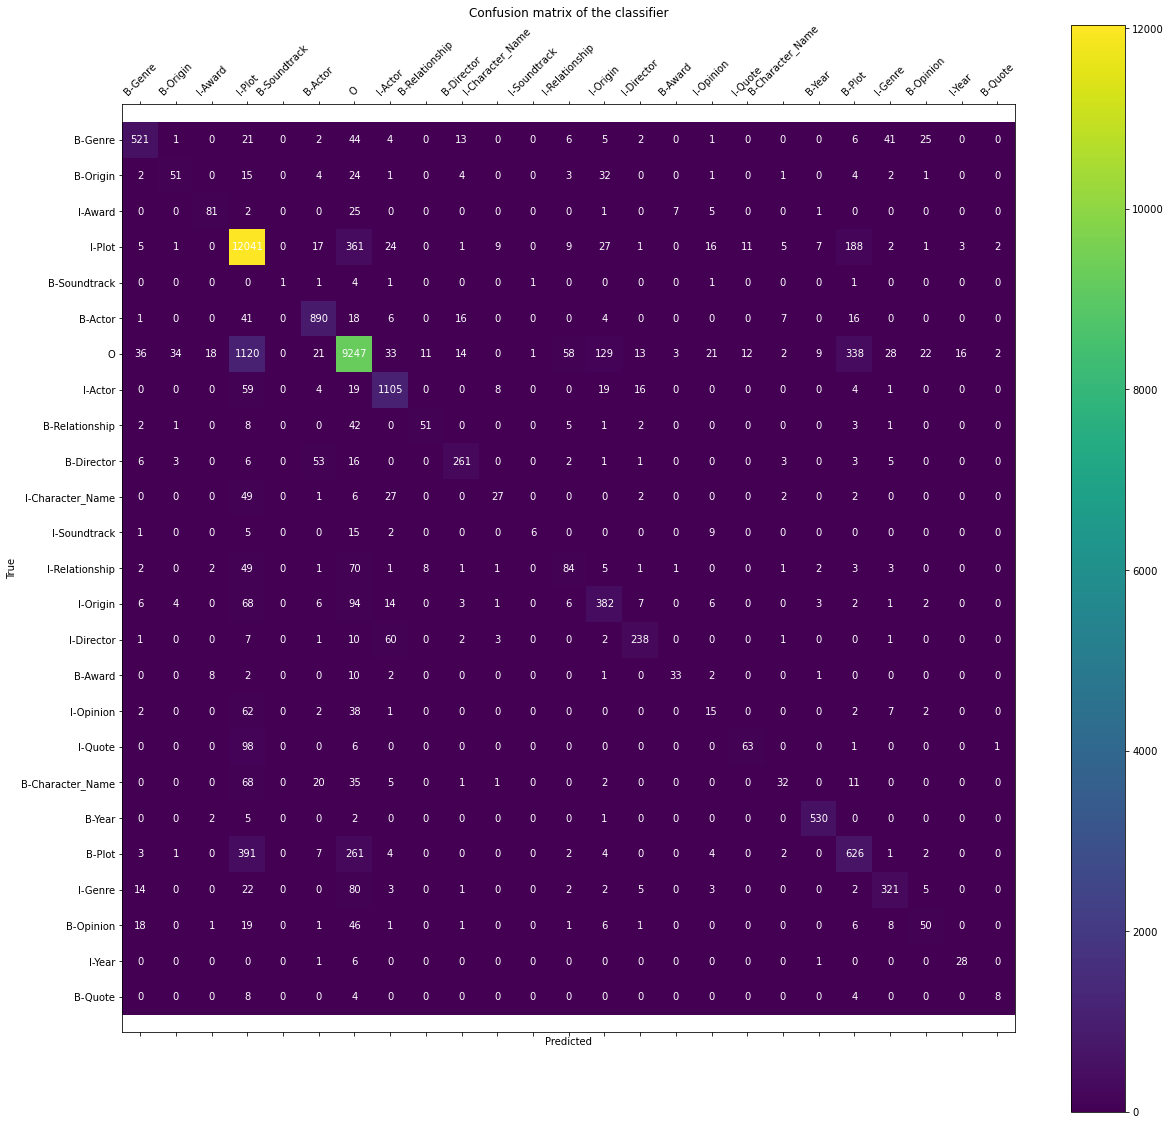

In [24]:
confusion_matrix_heatmap(y_test, preds)

# Question 5

In [25]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits
_pattern1 = re.compile(r"@")

# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    feature_list = []
    pos_tags = []
    
    

    if not token:
        return feature_list
    
    if re.search(_pattern1, token):
        token_tag = token.split('@')
        pos_tags.append('POS_' + token_tag[1])
        token = token_tag[0]
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 4
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
    if len(token) > 4:
        feature_list.append("SUF_" + token[-4:])

    # adding prefixes to our feature_list    
    # Prefix up to length 6
    if len(token) > 1:
        feature_list.append("PRE_" + token[0])
    if len(token) > 2:
        feature_list.append("PRE_" + token[:1])
    if len(token) > 3:
        feature_list.append("PRE_" + token[:2])
    if len(token) > 4:
        feature_list.append("PRE_" + token[:3])
    if len(token) > 5:
        feature_list.append("PRE_" + token[:4])
    if len(token) > 6:
        feature_list.append("PRE_" + token[:5])
        
        
    
    
    
    # Adding previous word with it's POS tag and length into feature list
    if idx > 0:
        prev_word_token = tokens[idx-1].split('@')[0]
        prev_pos = tokens[idx-1].split('@')[-1]
        feature_list.append('PREV_WORD_'+prev_word_token)
        feature_list.append('PREV_POS_'+prev_pos)
        feature_list.append('PREV_WORD_LENGTH_'+str(len(prev_word_token))) 
    else:
        feature_list.append('<s>')
        
    # Adding next word with POS tag and length into feature list    
    if idx < len(tokens)-1:
        next_word_token=tokens[idx+1].split('@')[0]
        next_pos = tokens[idx+1].split('@')[-1]
        feature_list.append('NEXT_WORD_'+next_word_token)
        feature_list.append('NEXT_POS_'+next_pos)
        feature_list.append('NEXT_WORD_LENGTH_'+str(len(next_word_token)))
    else:
        feature_list.append('</s>')
    
    # Adding the previous previous word (N-2), POS tags and length 
    if idx > 1:
        prev_prev_word_token = tokens[idx-2].split('@')[0]
        prev_prev_pos = tokens[idx-2].split('@')[-1]
        feature_list.append('PREV_PREV_WORD_'+prev_prev_word_token)
        feature_list.append('PREV_PREV_POS_'+prev_prev_pos)
        feature_list.append('PREV_PREV_WORD_LENGTH_'+str(len(prev_prev_word_token)))
        
        
        
    # Adding the next two words and POS tags      
    if idx < len(tokens)-2:
        next_next_word_token=tokens[idx+2].split('@')[0]
        next_next_pos = tokens[idx+2].split('@')[-1]
        feature_list.append('NEXT_NEXT_WORD_'+next_next_word_token)
        feature_list.append('NEXT_NEXT_POS_'+next_next_pos)
        feature_list.append('NEXT_NEXT_WORD_LENGTH_'+str(len(next_next_word_token)))
        
    # adding a trimmed version of the word by removing n,g,y and vowels    
    if idx >= 0:
        token_trimmed = re.sub(r'(.{2,}?)([ngyaeiou]+$)',r'\1', token.lower())
        feature_list.append('STEMMED_'+token_trimmed)

        
        
        
    feature_list.append("WORD_" + token)
    feature_list.extend(pos_tags)
    # Added word length to the feature list
    feature_list.append('WORD_LENGTH_'+ str(len(token)))
    #print(feature_list)
    return feature_list

In [27]:
# collecting the raw training data
training_data = get_raw_data_from_bio_file("./trivia10k13train.bio.txt")
# importing train_test_split in order to split the dataset
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(training_data, test_size=0.2, random_state=101)
X_train = preProcess(X_train)
X_test = preProcess(X_test)

# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features, training_opt={"feature.minfreq":2,'c1':0.2, 'c2':0.3, 'max_iterations': 100})  # initialize tagger with get_features function

print("training tagger...")
ct.train(X_train, TAGGER_PATH)
print("done")

training tagger...
done


In [28]:
print("testing tagger...")
preds = []
y_test = []
for sent in X_test:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [29]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))
# print out accurate macro score
print(precision_recall_fscore_support(y_test, preds, average='macro'))  

                  precision    recall  f1-score   support

         B-Actor       0.95      0.94      0.94       999
         B-Award       0.71      0.59      0.65        59
B-Character_Name       0.73      0.48      0.58       175
      B-Director       0.87      0.84      0.85       360
         B-Genre       0.83      0.79      0.81       692
       B-Opinion       0.45      0.32      0.37       159
        B-Origin       0.56      0.42      0.48       145
          B-Plot       0.51      0.48      0.49      1308
         B-Quote       0.83      0.42      0.56        24
  B-Relationship       0.64      0.45      0.53       116
    B-Soundtrack       1.00      0.10      0.18        10
          B-Year       0.96      0.98      0.97       540
         I-Actor       0.95      0.95      0.95      1235
         I-Award       0.70      0.68      0.69       122
I-Character_Name       0.70      0.51      0.59       116
      I-Director       0.90      0.88      0.89       326
         I-Ge

In [30]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features, 
               training_opt={"feature.minfreq":2,'c1':0.2, 'c2':0.3, 'max_iterations': 100})  # initialize tagger with get_features function

print("training tagger...")
ct.train(X_train, TAGGER_PATH)
print("done")

# setting a count to record the number of false negatives for each of the lowest precision categories
count_i_op = 0
count_b_op = 0
count_i_rl = 0
count_i_sd = 0
count_b_pl = 0
preds = []
y_test = []

for sent in X_test:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
    
    
    for i in range(len(sent_true)):
        if sent_preds[i] in lowest_precision:
            if sent_true[i] != sent_preds[i]:
                mistake = sent[i][0]
                print('SENTENCE: {0} \n, PREDICTED:    {1}, \n GROUND TRUTH: {2}, \n Incorrectly predicted word: {3} \n'.format([s[0].split('@')[0] for s in sent], sent_preds[i], sent_true[i], mistake.split('@')[0]))
                if sent_preds[i] == 'I-Opinion':
                    count_i_op += 1
                elif sent_preds[i] == 'B-Opinion':
                    count_b_op += 1
                elif sent_preds[i] == 'I-Relationship':
                    count_i_rl += 1
                elif sent_preds[i] == 'I-Soundtrack':
                    count_i_sd += 1
                else:
                    count_b_pl += 1

                    
                
print('\n')
print('Number of false positives for "I-Opinion": ',count_i_op)
print('Number of false positives for "B-Opinion": ',count_b_op)
print('Number of false positives for "I-Relationship": ',count_i_rl)
print('Number of false positives for "I-Soundtrack": ',count_i_sd)
print('Number of false positives for "B-Plot": ',count_b_pl)
print('\n')
print('\n')
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))
# print out accurate macro score
print(precision_recall_fscore_support(y_test, preds, average='macro'))  

training tagger...
done
SENTENCE: ['i', 'am', 'thinking', 'of', 'a', 'film', 'about', 'a', 'filmmaker', 'who', 'fondly', 'remembers', 'his', 'boyhood', 'and', 'his', 'fascination', 'with', 'films'] 
, PREDICTED:    B-Plot, 
 GROUND TRUTH: O, 
 Incorrectly predicted word: a 

SENTENCE: ['what', 'classic', 'thriller', 'about', 'an', 'enormous', 'killer', 'shark', 'spawned', 'one', 'of', 'the', 'most', 'popular', 'movie', 'themes', 'of', 'all', 'time'] 
, PREDICTED:    B-Opinion, 
 GROUND TRUTH: I-Soundtrack, 
 Incorrectly predicted word: most 

SENTENCE: ['what', 'classic', 'thriller', 'about', 'an', 'enormous', 'killer', 'shark', 'spawned', 'one', 'of', 'the', 'most', 'popular', 'movie', 'themes', 'of', 'all', 'time'] 
, PREDICTED:    I-Opinion, 
 GROUND TRUTH: I-Soundtrack, 
 Incorrectly predicted word: popular 

SENTENCE: ['name', 'the', 'oscar', 'nominated', 'film', 'starring', 'mark', 'wlaberg', 'playing', 'micky', 'ward', 'trying', 'to', 'get', 'into', 'pro', 'boxing'] 
, PREDICTED


SENTENCE: ['what', 'is', 'the', 'famous', 'movie', 'that', 'is', 'set', 'during', 'the', 'holocaust', 'in', 'poland', 'during', 'wwii', 'that', 'is', 'directed', 'by', 'spielberg'] 
, PREDICTED:    B-Opinion, 
 GROUND TRUTH: O, 
 Incorrectly predicted word: famous 

SENTENCE: ['name', 'the', 'futuristic', 'series', 'created', 'by', 'george', 'lucas', 'about', 'the', 'forces', 'of', 'good', 'and', 'evil'] 
, PREDICTED:    I-Relationship, 
 GROUND TRUTH: I-Genre, 
 Incorrectly predicted word: series 

SENTENCE: ['name', 'the', 'futuristic', 'series', 'created', 'by', 'george', 'lucas', 'about', 'the', 'forces', 'of', 'good', 'and', 'evil'] 
, PREDICTED:    B-Plot, 
 GROUND TRUTH: O, 
 Incorrectly predicted word: the 

SENTENCE: ['what', 'is', 'the', 'jude', 'law', 'movie', 'where', 'he', 'plays', 'a', 'man', 'who', 'takes', 'back', 'human', 'organs', 'if', 'the', 'people', 'ca', 'n', 't', 'pay', 'for', 'them'] 
, PREDICTED:    B-Plot, 
 GROUND TRUTH: I-Plot, 
 Incorrectly predicted word


SENTENCE: ['what', 'is', 'the', 'name', 'of', 'that', 'al', 'pacino', 'movie', 'where', 'he', 'has', 'a', 'beard', 'and', 'plays', 'a', 'new', 'york', 'cop'] 
, PREDICTED:    B-Plot, 
 GROUND TRUTH: O, 
 Incorrectly predicted word: he 

SENTENCE: ['which', 'bruce', 'lee', 'hong', 'kong', 'movie', 'includes', 'a', 'thrice', 'scratched', 'face', 'and', 'a', 'battle', 'in', 'a', 'mirror', 'maze'] 
, PREDICTED:    B-Plot, 
 GROUND TRUTH: I-Plot, 
 Incorrectly predicted word: thrice 

SENTENCE: ['what', 's', 'the', 'screwball', 'masterpiece', 'with', 'rapid', 'fire', 'dialogue', 'and', 'characters', 'who', 'are', 'in', 'the', 'newspaper', 'world'] 
, PREDICTED:    B-Plot, 
 GROUND TRUTH: O, 
 Incorrectly predicted word: rapid 

SENTENCE: ['what', 's', 'the', 'movie', 'that', 'is', 'a', 'live', 'action', 'retelling', 'of', 'a', 'famous', 'lewis', 'carroll', 'story'] 
, PREDICTED:    B-Plot, 
 GROUND TRUTH: O, 
 Incorrectly predicted word: live 

SENTENCE: ['this', 'science', 'fiction', 'mov

                  precision    recall  f1-score   support

         B-Actor       0.95      0.94      0.94       999
         B-Award       0.71      0.59      0.65        59
B-Character_Name       0.73      0.48      0.58       175
      B-Director       0.87      0.84      0.85       360
         B-Genre       0.83      0.79      0.81       692
       B-Opinion       0.45      0.32      0.37       159
        B-Origin       0.56      0.42      0.48       145
          B-Plot       0.51      0.48      0.49      1308
         B-Quote       0.83      0.42      0.56        24
  B-Relationship       0.64      0.45      0.53       116
    B-Soundtrack       1.00      0.10      0.18        10
          B-Year       0.96      0.98      0.97       540
         I-Actor       0.95      0.95      0.95      1235
         I-Award       0.70      0.68      0.69       122
I-Character_Name       0.70      0.51      0.59       116
      I-Director       0.90      0.88      0.89       326
         I-Ge

In [31]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))
# print out accurate macro score
print(precision_recall_fscore_support(y_test, preds, average='macro'))

                  precision    recall  f1-score   support

         B-Actor       0.95      0.94      0.94       999
         B-Award       0.71      0.59      0.65        59
B-Character_Name       0.73      0.48      0.58       175
      B-Director       0.87      0.84      0.85       360
         B-Genre       0.83      0.79      0.81       692
       B-Opinion       0.45      0.32      0.37       159
        B-Origin       0.56      0.42      0.48       145
          B-Plot       0.51      0.48      0.49      1308
         B-Quote       0.83      0.42      0.56        24
  B-Relationship       0.64      0.45      0.53       116
    B-Soundtrack       1.00      0.10      0.18        10
          B-Year       0.96      0.98      0.97       540
         I-Actor       0.95      0.95      0.95      1235
         I-Award       0.70      0.68      0.69       122
I-Character_Name       0.70      0.51      0.59       116
      I-Director       0.90      0.88      0.89       326
         I-Ge

In [32]:

# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features, 
               training_opt={"feature.minfreq":3,'c1':0.2, 'c2':0.3, 'max_iterations': 100})  # initialize tagger with get_features function

print("training tagger...")
ct.train(X_train, TAGGER_PATH)
print("done")

# setting a count to record the number of false negatives for each of the lowest precision categories
count_i_op = 0
count_b_op = 0
count_i_rl = 0
count_i_sd = 0
count_b_pl = 0
preds = []
y_test = []

for sent in X_test:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
    
    
    for i in range(len(sent_true)):
        if sent_preds[i] in lowest_precision:
            if sent_true[i] != sent_preds[i]:
                mistake = sent[i][0]
                print('SENTENCE: {0} \n, PREDICTED:    {1}, \n GROUND TRUTH: {2}, \n Incorrectly predicted word: {3} \n'.format([s[0].split('@')[0] for s in sent], sent_preds[i], sent_true[i], mistake.split('@')[0]))
                if sent_preds[i] == 'I-Opinion':
                    count_i_op += 1
                elif sent_preds[i] == 'B-Opinion':
                    count_b_op += 1
                elif sent_preds[i] == 'I-Relationship':
                    count_i_rl += 1
                elif sent_preds[i] == 'I-Soundtrack':
                    count_i_sd += 1
                else:
                    count_b_pl += 1

                    
                
print('\n')
print('Number of false positives for "I-Opinion": ',count_i_op)
print('Number of false positives for "B-Opinion": ',count_b_op)
print('Number of false positives for "I-Relationship": ',count_i_rl)
print('Number of false positives for "I-Soundtrack": ',count_i_sd)
print('Number of false positives for "B-Plot": ',count_b_pl)
print('\n')
print('\n')
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))
# print out accurate macro score
print(precision_recall_fscore_support(y_test, preds, average='macro'))  

training tagger...
done
SENTENCE: ['i', 'am', 'thinking', 'of', 'a', 'film', 'about', 'a', 'filmmaker', 'who', 'fondly', 'remembers', 'his', 'boyhood', 'and', 'his', 'fascination', 'with', 'films'] 
, PREDICTED:    B-Plot, 
 GROUND TRUTH: O, 
 Incorrectly predicted word: a 

SENTENCE: ['what', 'classic', 'thriller', 'about', 'an', 'enormous', 'killer', 'shark', 'spawned', 'one', 'of', 'the', 'most', 'popular', 'movie', 'themes', 'of', 'all', 'time'] 
, PREDICTED:    B-Opinion, 
 GROUND TRUTH: I-Soundtrack, 
 Incorrectly predicted word: most 

SENTENCE: ['what', 'classic', 'thriller', 'about', 'an', 'enormous', 'killer', 'shark', 'spawned', 'one', 'of', 'the', 'most', 'popular', 'movie', 'themes', 'of', 'all', 'time'] 
, PREDICTED:    I-Opinion, 
 GROUND TRUTH: I-Soundtrack, 
 Incorrectly predicted word: popular 

SENTENCE: ['name', 'the', 'oscar', 'nominated', 'film', 'starring', 'mark', 'wlaberg', 'playing', 'micky', 'ward', 'trying', 'to', 'get', 'into', 'pro', 'boxing'] 
, PREDICTED


SENTENCE: ['a', 'spoon', 'full', 'of', 'sugar', 'makes', 'the', 'medicine', 'go', 'down', 'in', 'this', '1964', 'classic'] 
, PREDICTED:    B-Opinion, 
 GROUND TRUTH: B-Genre, 
 Incorrectly predicted word: classic 

SENTENCE: ['what', 'is', 'the', 'famous', 'movie', 'that', 'is', 'set', 'during', 'the', 'holocaust', 'in', 'poland', 'during', 'wwii', 'that', 'is', 'directed', 'by', 'spielberg'] 
, PREDICTED:    B-Opinion, 
 GROUND TRUTH: O, 
 Incorrectly predicted word: famous 

SENTENCE: ['name', 'the', 'futuristic', 'series', 'created', 'by', 'george', 'lucas', 'about', 'the', 'forces', 'of', 'good', 'and', 'evil'] 
, PREDICTED:    I-Relationship, 
 GROUND TRUTH: I-Genre, 
 Incorrectly predicted word: series 

SENTENCE: ['name', 'the', 'futuristic', 'series', 'created', 'by', 'george', 'lucas', 'about', 'the', 'forces', 'of', 'good', 'and', 'evil'] 
, PREDICTED:    B-Plot, 
 GROUND TRUTH: O, 
 Incorrectly predicted word: the 

SENTENCE: ['what', 'is', 'the', 'jude', 'law', 'movie', '


SENTENCE: ['montgomery', 'clift', 'murders', 'shelley', 'winters', 'because', 'he', 'is', 'desperately', 'in', 'love', 'with', 'elizabeth', 'taylor', 'in', 'this', 'george', 'stevens', 'film'] 
, PREDICTED:    B-Opinion, 
 GROUND TRUTH: I-Plot, 
 Incorrectly predicted word: desperately 

SENTENCE: ['montgomery', 'clift', 'murders', 'shelley', 'winters', 'because', 'he', 'is', 'desperately', 'in', 'love', 'with', 'elizabeth', 'taylor', 'in', 'this', 'george', 'stevens', 'film'] 
, PREDICTED:    I-Opinion, 
 GROUND TRUTH: I-Plot, 
 Incorrectly predicted word: in 

SENTENCE: ['montgomery', 'clift', 'murders', 'shelley', 'winters', 'because', 'he', 'is', 'desperately', 'in', 'love', 'with', 'elizabeth', 'taylor', 'in', 'this', 'george', 'stevens', 'film'] 
, PREDICTED:    I-Opinion, 
 GROUND TRUTH: I-Plot, 
 Incorrectly predicted word: love 

SENTENCE: ['based', 'on', 'the', 'similar', 'battle', 'royale', 'and', 'lord', 'of', 'the', 'flies', 'this', 'movie', 'deals', 'with', 'children', '

                  precision    recall  f1-score   support

         B-Actor       0.94      0.93      0.94       999
         B-Award       0.73      0.59      0.65        59
B-Character_Name       0.70      0.45      0.55       175
      B-Director       0.87      0.84      0.85       360
         B-Genre       0.83      0.79      0.81       692
       B-Opinion       0.43      0.35      0.38       159
        B-Origin       0.54      0.42      0.47       145
          B-Plot       0.50      0.47      0.48      1308
         B-Quote       0.69      0.46      0.55        24
  B-Relationship       0.66      0.47      0.55       116
    B-Soundtrack       0.00      0.00      0.00        10
          B-Year       0.96      0.98      0.97       540
         I-Actor       0.93      0.94      0.94      1235
         I-Award       0.72      0.73      0.72       122
I-Character_Name       0.68      0.51      0.58       116
      I-Director       0.90      0.87      0.89       326
         I-Ge

In [33]:
# Final results on original test data, using all training data, with best settings from dev set:

# import both the testing the training data:
raw_train_data = get_raw_data_from_bio_file('trivia10k13train.bio.txt')
raw_test_data = get_raw_data_from_bio_file("trivia10k13test.bio.txt")

# preProcess both testing and training data
train_data = preProcess(raw_train_data)
test_data = preProcess(raw_test_data)
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")


# Train the CRF BIO-tag tagger on all training data
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(train_data, TAGGER_PATH)
print("done")

# load tagger from saved file
ct = CRFTagger(feature_func=get_features, 
               training_opt={"feature.minfreq":3,'c1':0.2, 'c2':0.3, 'max_iterations': 1000})  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

print("testing tagger on test data...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

1953 instances
39035 words
training tagger...
done
1953 instances
39035 words
testing tagger on test data...
done


In [34]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))
# print out accurate macro score
print(precision_recall_fscore_support(y_test, preds, average='macro')) 

                  precision    recall  f1-score   support

         B-Actor       0.93      0.94      0.94      1274
         B-Award       0.74      0.73      0.73        66
B-Character_Name       0.76      0.49      0.60       283
      B-Director       0.88      0.88      0.88       425
         B-Genre       0.82      0.81      0.81       789
       B-Opinion       0.45      0.36      0.40       195
        B-Origin       0.46      0.37      0.41       190
          B-Plot       0.50      0.48      0.49      1577
         B-Quote       0.89      0.36      0.52        47
  B-Relationship       0.77      0.56      0.65       171
    B-Soundtrack       1.00      0.12      0.22         8
          B-Year       0.97      0.98      0.97       661
         I-Actor       0.93      0.95      0.94      1553
         I-Award       0.80      0.77      0.78       147
I-Character_Name       0.77      0.52      0.62       227
      I-Director       0.94      0.91      0.92       411
         I-Ge